In [1]:
from transformers import BertModel,BertTokenizer,FlaubertTokenizer, FlaubertModel,AutoTokenizer, BertForSequenceClassification , FlaubertForSequenceClassification
from transformers.modeling_utils import SequenceSummary
from tensorboardX import SummaryWriter
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pack_padded_sequence
import sys
import re
from easy_nlp.models import BasicBertForClassification
from easy_nlp.training import Train
from easy_nlp.preprocessing import TextPreprocessing
from easy_nlp.feature_extraction import MetaFeaturesExtraction
from easy_nlp.data_visualisation import WordCloudMaker
from transformers import  AutoModel
 

/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [2]:
writer = SummaryWriter('runs/test')

In [3]:
import pandas as pd
df = pd.read_csv("/data/aboumada/Data/3_Datasets/processd_final_en_1.csv")
#df=df[df.classe2 != 'Poubelle']
len(df)

19250

In [4]:
text_preprocessing = TextPreprocessing(df,"text_clean")
text_preprocessing.fit_transform()

In [5]:
#df['processed_text']=df['processed_text'].str.replace(r'pic.twitter.com(.*?)\s(.*)', '')

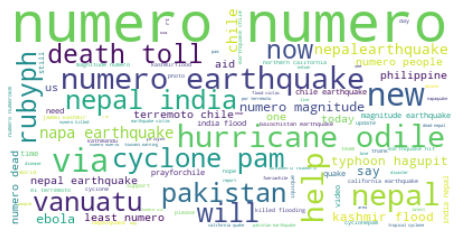

In [6]:
cloudMaker = WordCloudMaker.fit(df['processed_text'])

## Run if Random Sampling 

In [7]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df,random_state=1, test_size=0.2)


## Run if Out of event 

In [8]:
#events_test= ['Bruno', 'Eleanor']
#df_test = df[df.event.isin(events_test)]
#df_train = df[~df.event.isin(events_test)]

## Run if Out of Type 

In [9]:
#events_test= ['EffondrementMarseille']
#df_train=df_en[['text_clean','CAT']]

In [10]:
def get_sentences_labels(df,text_column='text_clean',label_column='CAT',cat_labels=None):
    dic_cat_labels = cat_labels if cat_labels is not None else {x:value for x,value in enumerate(df[label_column].unique())}
    dic_labels_to_cat = {value:x for x,value in dic_cat_labels.items() }
    #df[text_column]= df[text_column].map(lambda text_clean : re.sub('["#$%&()*+,-./:;<=>@[\]^_`{|}~\n\t’\']', '', text_clean))
    df2 = df[label_column].map(dic_labels_to_cat)
    sentences = df[text_column].values
    labels = df2.values.astype(int)
    return sentences,labels,dic_cat_labels

dic_cat_labels = {0: 'Avertissement-conseil', 1: 'Degats-Materiels', 2: 'AutresMessages', 3: 'Degats-Humains', 4: 'Message-NonUtilisable', 5: 'Soutiens', 6: 'Critiques'}
sentences_train,labels_train,dic_cat_labels=get_sentences_labels(df_train,text_column='processed_text',label_column='CAT',cat_labels=dic_cat_labels)
sentences_test,labels_test,dic_cat_labels=get_sentences_labels(df_test,text_column='processed_text',label_column='CAT',cat_labels=dic_cat_labels)

print(dic_cat_labels)


{0: 'Avertissement-conseil', 1: 'Soutiens', 2: 'AutresMessages', 3: 'Degats-Humains', 4: 'Degats-Materiels', 5: 'Message-NonUtilisable'}


### Scipy missed some words related to locations 
We will manually remove words lie __pakistan,india,nepal,vanuatu__

In [11]:
crisis_names = ['nepal','india','pakisran','chile','philippine']
#crisis_scrap = ['marseille','bruno','crue', 'crues', 'aude', 'carcassonne', 'trèbes', 'trebes','corse', 'corsica', 'hautecorse', 'haute-corse','crue','béryl', 'beryl', 'guadeloupe', 'ondetropicale','réunion', 'reunion', 'lareunion', 'fakir', 'laréunion','réunion', 'reunion', 'lareunion',' berguitta',' laréunion','corse', 'fionn', 'corsica', 'ana','irma','ouraganIRMA', 'saintmartin', 'stmartin', 'saintbarthelemy', 'saintbarth', 'stbarth','harvey', 'martinique', 'guadeloupe','egon','ulrika', 'vendée','bretagne','susanna']
crisis_scrap=crisis_names
for i in range(len(sentences_train)):
    big_regex = re.compile('|'.join(map(re.escape, crisis_scrap)))
    sentences_train[i] = big_regex.sub("Location", sentences_train[i])


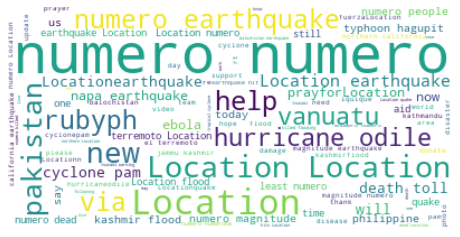

In [12]:
cloudMaker = WordCloudMaker.fit(sentences_train)

In [13]:
from sklearn.model_selection import train_test_split
from easy_nlp.feature_extraction import BertInput

bert_input= BertInput(AutoTokenizer.from_pretrained('bert-base-multilingual-cased'))


X_train = bert_input.fit_transform(sentences_train)
X_test = bert_input.fit_transform(sentences_test)


In [14]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels,train_masks,validation_masks = train_test_split(X_train[0], labels_train,X_train[1],random_state=1, test_size=0.2)
# Do the same for the masks.
#train_masks, validation_masks= train_test_split(,random_state=1, test_size=0.2)

test_inputs = X_test[0]
test_masks = X_test[1]
test_labels = labels_test

In [15]:
import torch 
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)





In [16]:
print(len(train_labels))

12320


In [17]:
def get_label_callback(dataset,idx):
    return dataset[idx][3].item()

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs,train_masks,train_labels)

'''If you need to iblancedsampler uncomment this line if not use RandomSampler'''
#train_sampler = ImbalancedDatasetSampler(train_data,callback_get_label=get_label_callback)
train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size,drop_last=True )

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs,validation_masks ,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs,test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [19]:
print(len(test_data[0]))

3


In [20]:
base_model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [21]:
model = BasicBertForClassification(base_model,7)
model.cuda()

BasicBertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Frezze Embeddings 
To keep the multilingual property of the model, we are going to freeze the embedding layer of the bert model

In [22]:
model.bert.embeddings.requires_grad = False


In [23]:
from transformers import AdamW,get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs 

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Run the tensoardBoard  tensorboard --logdir= "Path to your folder" to vizualize training 
__exemple__ :  tensorboard --logdir= runs/test

In [24]:
import numpy as np
criterion = nn.CrossEntropyLoss()
train = Train()
train.fit(model,train_dataloader,validation_dataloader,epochs,torch.device('cuda'),optimizer,scheduler,criterion,writer)
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    770.    Elapsed: 0:00:05.
  Batch    80  of    770.    Elapsed: 0:00:11.
  Batch   120  of    770.    Elapsed: 0:00:17.
  Batch   160  of    770.    Elapsed: 0:00:23.
  Batch   200  of    770.    Elapsed: 0:00:29.
  Batch   240  of    770.    Elapsed: 0:00:35.
  Batch   280  of    770.    Elapsed: 0:00:41.
  Batch   320  of    770.    Elapsed: 0:00:47.
  Batch   360  of    770.    Elapsed: 0:00:53.
  Batch   400  of    770.    Elapsed: 0:00:59.
  Batch   440  of    770.    Elapsed: 0:01:05.
  Batch   480  of    770.    Elapsed: 0:01:11.
  Batch   520  of    770.    Elapsed: 0:01:17.
  Batch   560  of    770.    Elapsed: 0:01:23.
  Batch   600  of    770.    Elapsed: 0:01:29.
  Batch   640  of    770.    Elapsed: 0:01:35.
  Batch   680  of    770.    Elapsed: 0:01:41.
  Batch   720  of    770.    Elapsed: 0:01:47.
  Batch   760  of    770.    Elapsed: 0:01:53.

  Average training loss: 0.80
  Training epcoh took: 0:01:54

R

/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aboumada/anaconda3/envs/torch_tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
save currently the best model to [tmp]
save model parameters to [tmp]


  Accuracy: 0.77
  F1: 0.69
  Recall: 0.72
  Precision: 0.72
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    770.    Elapsed: 0:00:06.
  Batch    80  of    770.    Elapsed: 0:00:12.
  Batch   120  of    770.    Elapsed: 0:00:18.
  Batch   160  of    770.    Elapsed: 0:00:24.
  Batch   200  of    770.    Elapsed: 0:00:30.
  Batch   240  of    770.    Elapsed: 0:00:36.
  Batch   280  of    770.    Elapsed: 0:00:42.
  Batch   320  of    770.    Elapsed: 0:00:48.
  Batch   360  of    770.    Elapsed: 0:00:54.
  Batch   400  of    770.    Elapsed: 0:01:00.
  Batch   440  of    770.    Elapsed: 0:01:06.
  Batch   480  of    770.    Elapsed: 0:01:12.
  Batch   520  of    770.    Elapsed: 0:01:18.
  Batch   560  of    770.    Elapsed: 0:01:24.
  Batch   600  of    770.    Elapsed: 0:01:30.
  Batch   640  of    770.    Elapsed: 0:01:36.
  Batch   680  of    770.    Elapsed: 0:01:42.
  Batch   720  of    770.    Elapsed: 0:01:48.
  Batch   760  of    77

save currently the best model to [tmp]
save model parameters to [tmp]


  Accuracy: 0.78
  F1: 0.71
  Recall: 0.73
  Precision: 0.73
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    770.    Elapsed: 0:00:06.
  Batch    80  of    770.    Elapsed: 0:00:12.
  Batch   120  of    770.    Elapsed: 0:00:18.
  Batch   160  of    770.    Elapsed: 0:00:24.
  Batch   200  of    770.    Elapsed: 0:00:30.
  Batch   240  of    770.    Elapsed: 0:00:36.
  Batch   280  of    770.    Elapsed: 0:00:42.
  Batch   320  of    770.    Elapsed: 0:00:48.
  Batch   360  of    770.    Elapsed: 0:00:54.
  Batch   400  of    770.    Elapsed: 0:01:00.
  Batch   440  of    770.    Elapsed: 0:01:06.
  Batch   480  of    770.    Elapsed: 0:01:12.
  Batch   520  of    770.    Elapsed: 0:01:18.
  Batch   560  of    770.    Elapsed: 0:01:24.
  Batch   600  of    770.    Elapsed: 0:01:30.
  Batch   640  of    770.    Elapsed: 0:01:36.
  Batch   680  of    770.    Elapsed: 0:01:42.
  Batch   720  of    770.    Elapsed: 0:01:48.
  Batch   760  of    77

In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataloader)))

# Put model in evaluation mode
model.eval()


# Tracking variables 
predictions_cat,predictions_cat3,predictions_cat2 , true_labels_cat,true_labels_cat2  = [], [],[],[],[]

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(torch.device("cuda")) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask,b_labels_cat = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model((b_input_ids,b_input_mask))
        logits_cat = outputs[0]

    # Move logits and labels to CPU
    logits_cat = logits_cat.detach().cpu().numpy()
    label_ids_cat = b_labels_cat.to('cpu').numpy()
    predictions_cat.extend(logits_cat)
    true_labels_cat.extend(label_ids_cat)
    

    



print('    DONE.')



Predicting labels for 241 test sentences...
    DONE.


In [26]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

pred_flat_cat = np.argmax(predictions_cat, axis=1)
true_labels_cat=[dic_cat_labels.get(x) for x in true_labels_cat]
pred_flat_cat = [dic_cat_labels.get(x) for x in pred_flat_cat]


cr= classification_report(true_labels_cat,pred_flat_cat,digits=4)
print(accuracy_score(pred_flat_cat,true_labels_cat))
print(cr)

0.7833766233766234
                       precision    recall  f1-score   support

       AutresMessages     0.7404    0.7582    0.7492      1249
Avertissement-conseil     0.6211    0.5000    0.5540       200
       Degats-Humains     0.9063    0.9317    0.9188       571
     Degats-Materiels     0.6788    0.7168    0.6973       286
Message-NonUtilisable     0.7844    0.6527    0.7125       524
             Soutiens     0.8203    0.8725    0.8456      1020

             accuracy                         0.7834      3850
            macro avg     0.7586    0.7387    0.7462      3850
         weighted avg     0.7814    0.7834    0.7809      3850



In [27]:
model.save("crisis_nlp_trained_model")

save model parameters to [crisis_nlp_trained_model]


## Do training with pretrained weights on our task 

In [28]:
df = pd.read_csv("/data/aboumada/Data/3_Datasets/full_df_noFeatures_Preapred.csv")


In [29]:
text_preprocessing = TextPreprocessing(df,"TEXT")
text_preprocessing.fit_transform()

## Run if Random Sampling 

In [30]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df,random_state=1, test_size=0.2)


## Run if Out of event 

In [31]:
#events_test= ['Bruno', 'Eleanor']
#df_test = df[df.event.isin(events_test)]
#df_train = df[~df.event.isin(events_test)]

## Run if Out of Type 

In [32]:
#events_test= ['EffondrementMarseille']
#df_train=df_en[['text_clean','CAT']]

In [33]:
def get_sentences_labels(df,text_column='text_clean',label_column='CAT',cat_labels=None):
    dic_cat_labels = cat_labels if cat_labels is not None else {x:value for x,value in enumerate(df[label_column].unique())}
    dic_labels_to_cat = {value:x for x,value in dic_cat_labels.items() }
    #df[text_column]= df[text_column].map(lambda text_clean : re.sub('["#$%&()*+,-./:;<=>@[\]^_`{|}~\n\t’\']', '', text_clean))
    df2 = df[label_column].map(dic_labels_to_cat)
    sentences = df[text_column].values
    labels = df2.values.astype(int)
    return sentences,labels,dic_cat_labels

sentences_train,labels_train,dic_cat_labels=get_sentences_labels(df_train,text_column='processed_text',label_column='CAT',cat_labels=dic_cat_labels)
sentences_test,labels_test,dic_cat_labels=get_sentences_labels(df_test,text_column='processed_text',label_column='CAT',cat_labels=dic_cat_labels)

print(dic_cat_labels)


{0: 'Avertissement-conseil', 1: 'Soutiens', 2: 'AutresMessages', 3: 'Degats-Humains', 4: 'Degats-Materiels', 5: 'Message-NonUtilisable'}


In [34]:
from sklearn.model_selection import train_test_split
from easy_nlp.feature_extraction import BertInput

bert_input= BertInput(AutoTokenizer.from_pretrained('bert-base-multilingual-cased'))


X_train = bert_input.fit_transform(sentences_train)
X_test = bert_input.fit_transform(sentences_test)


In [35]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels,train_masks,validation_masks = train_test_split(X_train[0], labels_train,X_train[1],random_state=1, test_size=0.2)
# Do the same for the masks.
#train_masks, validation_masks= train_test_split(,random_state=1, test_size=0.2)

test_inputs = X_test[0]
test_masks = X_test[1]
test_labels = labels_test

In [36]:
import torch 
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)





In [37]:
def get_label_callback(dataset,idx):
    return dataset[idx][3].item()

In [38]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs,train_masks,train_labels)

'''If you need to iblancedsampler uncomment this line if not use RandomSampler'''
#train_sampler = ImbalancedDatasetSampler(train_data,callback_get_label=get_label_callback)
train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size,drop_last=True )

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs,validation_masks ,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs,test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [39]:
from transformers import AdamW,get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs 

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [40]:
import numpy as np
criterion = nn.CrossEntropyLoss()
train = Train()
train.fit(model,train_dataloader,validation_dataloader,epochs,torch.device('cuda'),optimizer,scheduler,criterion,writer)
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    513.    Elapsed: 0:00:09.
  Batch    80  of    513.    Elapsed: 0:00:18.
  Batch   120  of    513.    Elapsed: 0:00:28.
  Batch   160  of    513.    Elapsed: 0:00:37.
  Batch   200  of    513.    Elapsed: 0:00:46.
  Batch   240  of    513.    Elapsed: 0:00:55.
  Batch   280  of    513.    Elapsed: 0:01:04.
  Batch   320  of    513.    Elapsed: 0:01:13.
  Batch   360  of    513.    Elapsed: 0:01:23.
  Batch   400  of    513.    Elapsed: 0:01:32.
  Batch   440  of    513.    Elapsed: 0:01:41.
  Batch   480  of    513.    Elapsed: 0:01:50.

  Average training loss: 0.60
  Training epcoh took: 0:01:58

Running Validation...


save currently the best model to [tmp]
save model parameters to [tmp]


  Accuracy: 0.83
  F1: 0.59
  Recall: 0.61
  Precision: 0.60
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    513.    Elapsed: 0:00:09.
  Batch    80  of    513.    Elapsed: 0:00:18.
  Batch   120  of    513.    Elapsed: 0:00:28.
  Batch   160  of    513.    Elapsed: 0:00:37.
  Batch   200  of    513.    Elapsed: 0:00:46.
  Batch   240  of    513.    Elapsed: 0:00:55.
  Batch   280  of    513.    Elapsed: 0:01:04.
  Batch   320  of    513.    Elapsed: 0:01:14.
  Batch   360  of    513.    Elapsed: 0:01:23.
  Batch   400  of    513.    Elapsed: 0:01:32.
  Batch   440  of    513.    Elapsed: 0:01:41.
  Batch   480  of    513.    Elapsed: 0:01:50.

  Average training loss: 0.40
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.82
  F1: 0.59
  Recall: 0.63
  Precision: 0.59
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    513.    Elapsed: 0:00:09.
  Batch    80  of    513.    Elapsed: 0:00

save currently the best model to [tmp]
save model parameters to [tmp]


  Accuracy: 0.83
  F1: 0.59
  Recall: 0.61
  Precision: 0.60
  Validation took: 0:00:09

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    513.    Elapsed: 0:00:09.
  Batch    80  of    513.    Elapsed: 0:00:18.
  Batch   120  of    513.    Elapsed: 0:00:27.
  Batch   160  of    513.    Elapsed: 0:00:37.
  Batch   200  of    513.    Elapsed: 0:00:46.
  Batch   240  of    513.    Elapsed: 0:00:55.
  Batch   280  of    513.    Elapsed: 0:01:04.
  Batch   320  of    513.    Elapsed: 0:01:13.
  Batch   360  of    513.    Elapsed: 0:01:22.
  Batch   400  of    513.    Elapsed: 0:01:32.
  Batch   440  of    513.    Elapsed: 0:01:41.
  Batch   480  of    513.    Elapsed: 0:01:50.

  Average training loss: 0.18
  Training epcoh took: 0:01:57

Running Validation...


save currently the best model to [tmp]
save model parameters to [tmp]


  Accuracy: 0.84
  F1: 0.63
  Recall: 0.65
  Precision: 0.64
  Validation took: 0:00:10

Training complete!


In [43]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataloader)))

# Put model in evaluation mode
model.eval()


# Tracking variables 
predictions_cat,predictions_cat3,predictions_cat2 , true_labels_cat,true_labels_cat2  = [], [],[],[],[]

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(torch.device("cuda")) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask,b_labels_cat = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model((b_input_ids,b_input_mask))
        logits_cat = outputs[0]

    # Move logits and labels to CPU
    logits_cat = logits_cat.detach().cpu().numpy()
    label_ids_cat = b_labels_cat.to('cpu').numpy()
    predictions_cat.extend(logits_cat)
    true_labels_cat.extend(label_ids_cat)
    

    



print('    DONE.')
print(dic_cat_labels)


Predicting labels for 161 test sentences...
    DONE.
{0: 'Avertissement-conseil', 1: 'Soutiens', 2: 'AutresMessages', 3: 'Degats-Humains', 4: 'Degats-Materiels', 5: 'Message-NonUtilisable'}


In [42]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

pred_flat_cat = np.argmax(predictions_cat, axis=1)
true_labels_cat=[dic_cat_labels.get(x) for x in true_labels_cat]
pred_flat_cat = [dic_cat_labels.get(x) for x in pred_flat_cat]


cr= classification_report(true_labels_cat,pred_flat_cat,digits=4)
print(accuracy_score(pred_flat_cat,true_labels_cat))
print(cr)

TypeError: '<' not supported between instances of 'str' and 'NoneType'

In [ ]:
model.save("Crisis_Binary_flaubert_base.pth")